In [1]:
import numpy as np
from channel import WirelessChannel
from network import WirelessNetwork
from regnn import REGNN, train_unconstrained, train_primal_dual
from utils import plot_pathloss, ribbon_by_distance, scatter_network, avg_loss_cap_pow

d0, gamma, s, N0 = 1.0, 2.2, 2.0, 1e-6

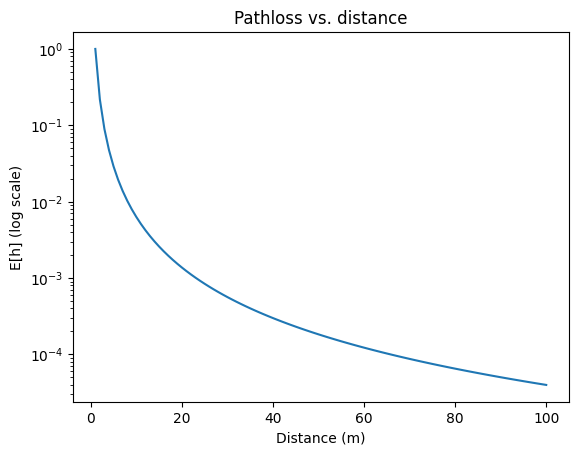

In [24]:
wc = 50.0  # (not used here; just keeping constants nearby)
ch = WirelessChannel(d0=d0, gamma=gamma, s=s, N0=N0, rng=7)
dvals = np.linspace(1, 100, 100)
Eh = ch.pathloss(dvals)
plot_pathloss(dvals, Eh)


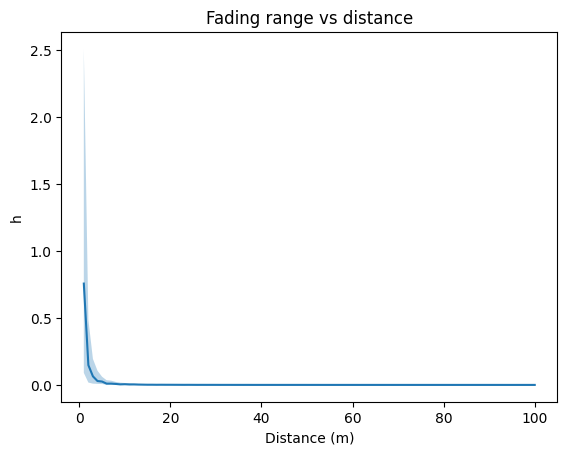

In [25]:
samples = []
for d in dvals:
    samples.append(ch.sample_fading(q=100, d=d))
ribbon_by_distance(dvals, samples, ylabel='h', title='Fading range vs distance')

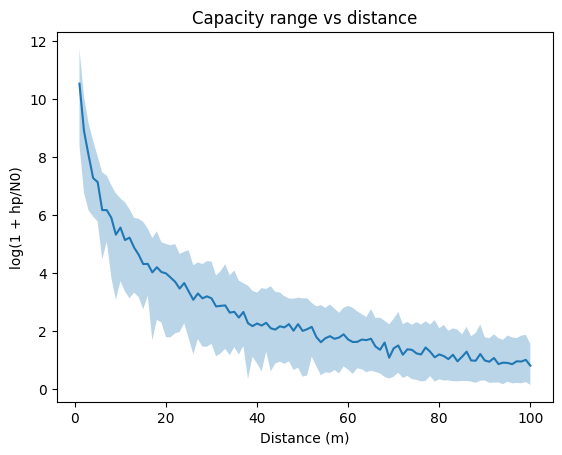

In [26]:
P_const = 0.05
cap_samples = [ch.capacity(P_const, np.asarray(x)) for x in samples]
ribbon_by_distance(dvals, cap_samples, ylabel='log(1 + hp/N0)', title='Capacity range vs distance')

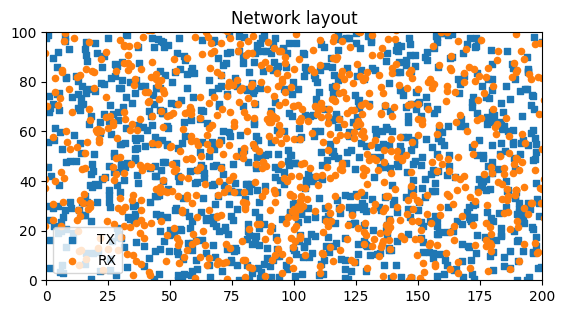

In [27]:
wx, wy, wc = 200, 100, 50
rho = 0.05
n = int(rho * wx * wy)  
net = WirelessNetwork(n=n, wx=wx, wy=wy, wc=wc, d0=d0, gamma=gamma, s=s, N0=N0, rng=123)
scatter_network(net.tx, net.rx, wx, wy)

H_q = net.sample_H(q=3)

In [2]:
wx, wy, wc = 80, 40, 20
n = int(0.05 * wx * wy)
net3 = WirelessNetwork(n=n, wx=wx, wy=wy, wc=wc, d0=d0, gamma=gamma, s=s, N0=N0, rng=42)

model = REGNN(n_features=[8,4,1], K=5)
model = train_unconstrained(model, net3,
                            steps=200,
                            batch_graphs=100,
                            mu=0.05,         
                            lr=5e-4)     

H_eval = net3.sample_H(q=160)
avg_loss, avg_caps_per_node, avg_pow_per_node = avg_loss_cap_pow(model, H_eval, N0)
avg_loss, avg_caps_per_node[:5], avg_pow_per_node[:5]

(np.float32(0.18339756),
 array([0.03710604, 0.16098784, 0.02593916, 0.07850544, 1.23751   ],
       dtype=float32),
 array([0.06666667, 0.06666667, 0.06666667, 0.06666667, 0.06666667],
       dtype=float32))

In [3]:
p_budget = 1e-3
model_c = REGNN(n_features=[8,4,1], K=5, pmax=1.2e-3)
model_c, mu_vec = train_primal_dual(
    model_c, net3,
    steps=800,
    batch_graphs=100,
    p_budget=p_budget,
    lr_primal=1e-3,  
    lr_dual=3e-1)


H_eval = net3.sample_H(q=100)
avg_loss_c, avg_caps_node_c, avg_pow_node_c = avg_loss_cap_pow(model_c, H_eval, N0)
(avg_loss_c, avg_caps_node_c[:5], avg_pow_node_c[:5], mu_vec[:5])


(np.float32(0.18444568),
 array([0.03333695, 0.16318804, 0.02188146, 0.06697058, 1.4183218 ],
       dtype=float32),
 array([0.0008, 0.0008, 0.0008, 0.0008, 0.0008], dtype=float32),
 array([0.9519826 , 0.9519832 , 0.95198256, 0.95198256, 0.95198375],
       dtype=float32))

In [4]:
import numpy as np

def report(tag, avg_loss, caps, pows, budget=None):
    print(f"=== {tag} ===")
    if budget is not None:
        print(f"Power budget per node: {budget:.6f}")
    print(f"Average loss (mean capacity): {float(avg_loss):.6f}")
    print(f"capacities[:5] = {np.round(caps[:5], 6)}")
    print(f"powers[:5]     = {np.round(pows[:5], 6)}")
    print(f"mean power     = {float(np.mean(pows)):.6f}")
    print()

# Re-evaluate both models on fresh samples
H_eval_u = net3.sample_H(q=160)
avg_loss_u, caps_u, pows_u = avg_loss_cap_pow(model, H_eval_u, N0)

H_eval_c = net3.sample_H(q=100)
avg_loss_c, caps_c, pows_c = avg_loss_cap_pow(model_c, H_eval_c, N0)

report("Section 3.1 (Unconstrained)", avg_loss_u, caps_u, pows_u)
report("Section 4.1 (Constrained)",   avg_loss_c, caps_c, pows_c, budget=p_budget)


=== Section 3.1 (Unconstrained) ===
Average loss (mean capacity): 0.184277
capacities[:5] = [0.038375 0.158381 0.023856 0.074999 1.28858 ]
powers[:5]     = [0.066667 0.066667 0.066667 0.066667 0.066667]
mean power     = 0.066667

=== Section 4.1 (Constrained) ===
Power budget per node: 0.001000
Average loss (mean capacity): 0.184549
capacities[:5] = [0.042349 0.148348 0.023847 0.080284 1.201098]
powers[:5]     = [0.0008 0.0008 0.0008 0.0008 0.0008]
mean power     = 0.000800



In [5]:
# --- For Unconstrained (3.2 and 3.3) ---
import numpy as np

losses_160 = []
losses_360 = []

for i in range(100):
    H_eval = net3.sample_H(q=160)
    avg_loss, _, _ = avg_loss_cap_pow(model, H_eval, N0)
    losses_160.append(avg_loss)
    
    H_eval = net3.sample_H(q=360)
    avg_loss, _, _ = avg_loss_cap_pow(model, H_eval, N0)
    losses_360.append(avg_loss)

print("=== 3.2 (Unconstrained, q=160) ===")
print("Average loss:", np.mean(losses_160))
print("Loss variance:", np.var(losses_160))

print("\n=== 3.3 (Unconstrained, q=360) ===")
print("Average loss:", np.mean(losses_360))
print("Loss variance:", np.var(losses_360))


=== 3.2 (Unconstrained, q=160) ===
Average loss: 0.18466508
Loss variance: 2.3716682e-06

=== 3.3 (Unconstrained, q=360) ===
Average loss: 0.18477081
Loss variance: 1.0660509e-06


In [6]:
losses_c_160 = []
losses_c_360 = []

for i in range(100):
    H_eval = net3.sample_H(q=160)
    avg_loss, _, _ = avg_loss_cap_pow(model_c, H_eval, N0)
    losses_c_160.append(avg_loss)

    H_eval = net3.sample_H(q=360)
    avg_loss, _, _ = avg_loss_cap_pow(model_c, H_eval, N0)
    losses_c_360.append(avg_loss)

print("=== 4.2 (Constrained, q=160) ===")
print("Average loss:", np.mean(losses_c_160))
print("Loss variance:", np.var(losses_c_160))

print("\n=== 4.3 (Constrained, q=360) ===")
print("Average loss:", np.mean(losses_c_360))
print("Loss variance:", np.var(losses_c_360))


=== 4.2 (Constrained, q=160) ===
Average loss: 0.18436275
Loss variance: 1.7675322e-06

=== 4.3 (Constrained, q=360) ===
Average loss: 0.18430626
Loss variance: 1.2974949e-06
